In [ ]:
import sys
import matplotlib.pyplot as plt
from pathlib import Path

# Agregar el directorio raíz del proyecto al path
root_dir = Path().resolve().parents[1]
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

import numpy as np

from src.utils.fonts_processor import load_fonts, get_char_labels
from src.models.components.optimizers import SGD, Momentum, Adam
from src.models.components.loss import bce, bce_prime
from src.models.components.mlp import MLP
from src.models.components.layers import Dense
from src.models.components.activation import Tanh, Sigmoid

In [22]:

INPUT_DIM = 35  # 7x5
EPOCHS = 9000
LATENT_DIM = 2

# Cargar datos
X_train = load_fonts()
char_labels = get_char_labels()

print(f"Datos cargados: {len(X_train)} patrones de dimensión {INPUT_DIM}")
print(f"Primeros caracteres: {char_labels[:5]}")

Datos cargados: 32 patrones de dimensión 35
Primeros caracteres: ['`', 'a', 'b', 'c', 'd']


## Búsqueda de la Mejor Arquitectura
Comparación de diferentes configuraciones para encontrar una arquitectura que logre ≤ 1 píxel de error por letra

In [23]:
def train_and_evaluate(config_name, layers, loss_fn, loss_prime_fn, optimizer, epochs=5000):
    """
    Entrena un autoencoder con la configuración dada y evalúa su rendimiento.
    Retorna: nombre, promedio de píxeles incorrectos, max píxeles incorrectos, pérdida final
    """
    print(f"\n{'='*60}")
    print(f"Entrenando: {config_name}")
    print(f"{'='*60}")
    
    # Crear y entrenar el modelo
    ae = MLP(layers=layers, loss=loss_fn, loss_prime=loss_prime_fn, optimizer=optimizer)
    X_train_reshaped = np.array([x.reshape(-1, 1) for x in X_train])
    y_train = X_train_reshaped.copy()
    
    history = ae.train(X_train_reshaped, y_train, epochs=epochs, batch_size=1, verbose=False)
    
    # Evaluar píxeles incorrectos
    incorrect_pixels = []
    for i in range(len(X_train)):
        X_original = X_train[i]
        X_reconstructed = ae.forward(X_original.reshape(-1, 1))
        incorrect = count_incorrect_pixels(X_original, X_reconstructed)
        incorrect_pixels.append(incorrect)
    
    avg_incorrect = np.mean(incorrect_pixels)
    max_incorrect = np.max(incorrect_pixels)
    final_loss = history[-1]
    
    print(f"✓ Píxeles incorrectos promedio: {avg_incorrect:.2f}")
    print(f"✓ Píxeles incorrectos máximo: {max_incorrect}")
    print(f"✓ Pérdida final: {final_loss:.6f}")
    
    return {
        'name': config_name,
        'avg_incorrect': avg_incorrect,
        'max_incorrect': max_incorrect,
        'final_loss': final_loss,
        'history': history,
        'incorrect_pixels': incorrect_pixels,
        'model': ae
    }

print("Función de evaluación lista.")

Función de evaluación lista.


In [24]:
def count_incorrect_pixels(X_original, X_reconstructed):
    """
    Cuenta cuántos píxeles están incorrectos entre la imagen original y reconstruida.
    Redondea la reconstrucción a 0 o 1 antes de comparar.
    """
    X_recon_rounded = (X_reconstructed.flatten() > 0.5).astype(float)
    X_orig_flat = X_original.flatten()
    
    # Contar píxeles diferentes
    incorrect = np.sum(X_recon_rounded != X_orig_flat)
    return int(incorrect)

In [25]:
# Definir configuraciones a probar
configurations = []

# 1. Variaciones de arquitectura (hidden layer size)
for hidden_size in [8, 16, 24, 32]:
    layers = [
        Dense(INPUT_DIM, hidden_size), Tanh(),
        Dense(hidden_size, LATENT_DIM), Tanh(),
        Dense(LATENT_DIM, hidden_size), Tanh(),
        Dense(hidden_size, INPUT_DIM), Sigmoid()
    ]
    configurations.append({
        'name': f'Arch_h{hidden_size}',
        'layers': layers,
        'loss': bce,
        'loss_prime': bce_prime,
        'optimizer': Adam(learning_rate=0.001)
    })

# 2. Variaciones de optimizador (con hidden=24)
optimizers_to_test = [
    ('Adam_lr0.001', Adam(learning_rate=0.001)),
    ('Adam_lr0.005', Adam(learning_rate=0.005)),
    ('Momentum_lr0.05', Momentum(learning_rate=0.05, momentum=0.9)),
    ('Momentum_lr0.01', Momentum(learning_rate=0.01, momentum=0.9)),
]

for opt_name, opt in optimizers_to_test:
    layers = [
        Dense(INPUT_DIM, 24), Tanh(),
        Dense(24, LATENT_DIM), Tanh(),
        Dense(LATENT_DIM, 24), Tanh(),
        Dense(24, INPUT_DIM), Sigmoid()
    ]
    configurations.append({
        'name': f'Opt_{opt_name}',
        'layers': layers,
        'loss': bce,
        'loss_prime': bce_prime,
        'optimizer': opt
    })

# 3. COMPARACIÓN: Sigmoid vs Tanh en capas ocultas
activation_comparisons = [
    ('AllSigmoid_h16', [
        Dense(INPUT_DIM, 16), Sigmoid(),
        Dense(16, LATENT_DIM), Sigmoid(),
        Dense(LATENT_DIM, 16), Sigmoid(),
        Dense(16, INPUT_DIM), Sigmoid()
    ]),
    ('AllTanh_h16', [
        Dense(INPUT_DIM, 16), Tanh(),
        Dense(16, LATENT_DIM), Tanh(),
        Dense(LATENT_DIM, 16), Tanh(),
        Dense(16, INPUT_DIM), Tanh()  # Tanh en salida (malo para BCE)
    ]),
    ('AllSigmoid_h24', [
        Dense(INPUT_DIM, 24), Sigmoid(),
        Dense(24, LATENT_DIM), Sigmoid(),
        Dense(LATENT_DIM, 24), Sigmoid(),
        Dense(24, INPUT_DIM), Sigmoid()
    ])
]

for act_name, layers in activation_comparisons:
    configurations.append({
        'name': act_name,
        'layers': layers,
        'loss': bce,
        'loss_prime': bce_prime,
        'optimizer': Adam(learning_rate=0.001)
    })

# 4. Arquitecturas más profundas
for depth_config in [
    ('Deep_64-32', [
        Dense(INPUT_DIM, 64), Tanh(),
        Dense(64, 32), Tanh(),
        Dense(32, LATENT_DIM), Tanh(),
        Dense(LATENT_DIM, 32), Tanh(),
        Dense(32, 64), Tanh(),
        Dense(64, INPUT_DIM), Sigmoid()
    ]),
    ('Deep_32-16-8', [
        Dense(INPUT_DIM, 32), Tanh(),
        Dense(32, 16), Tanh(),
        Dense(16, 8), Tanh(),
        Dense(8, LATENT_DIM), Tanh(),
        Dense(LATENT_DIM, 8), Tanh(),
        Dense(8, 16), Tanh(),
        Dense(16, 32), Tanh(),
        Dense(32, INPUT_DIM), Sigmoid()
    ]),
]:
    name, layers = depth_config
    configurations.append({
        'name': name,
        'layers': layers,
        'loss': bce,
        'loss_prime': bce_prime,
        'optimizer': Adam(learning_rate=0.001)
    })

print(f"Total de configuraciones a probar: {len(configurations)}")
print("\n📊 Configuraciones de activación añadidas:")
print("  - AllSigmoid_h16: Todas las capas con Sigmoid (esperado: malo por vanishing gradient)")
print("  - AllTanh_h16: Todas las capas con Tanh (esperado: malo en salida con BCE)")
print("  - TanhSigmoid_h16: Tanh en ocultas, Sigmoid en salida (esperado: ✅ óptimo)")
print("  - AllSigmoid_h24: Todas Sigmoid con más neuronas")
print("  - TanhSigmoid_h24: Tanh+Sigmoid con más neuronas (esperado: ✅ mejor)")

Total de configuraciones a probar: 13

📊 Configuraciones de activación añadidas:
  - AllSigmoid_h16: Todas las capas con Sigmoid (esperado: malo por vanishing gradient)
  - AllTanh_h16: Todas las capas con Tanh (esperado: malo en salida con BCE)
  - TanhSigmoid_h16: Tanh en ocultas, Sigmoid en salida (esperado: ✅ óptimo)
  - AllSigmoid_h24: Todas Sigmoid con más neuronas
  - TanhSigmoid_h24: Tanh+Sigmoid con más neuronas (esperado: ✅ mejor)


In [26]:
# Entrenar y evaluar todas las configuraciones
results = []

for config in configurations:
    result = train_and_evaluate(
        config_name=config['name'],
        layers=config['layers'],
        loss_fn=config['loss'],
        loss_prime_fn=config['loss_prime'],
        optimizer=config['optimizer'],
        epochs=5000
    )
    results.append(result)

print(f"\n{'='*60}")
print("ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")


Entrenando: Arch_h8


✓ Píxeles incorrectos promedio: 2.56
✓ Píxeles incorrectos máximo: 7
✓ Pérdida final: 0.183953

Entrenando: Arch_h16
✓ Píxeles incorrectos promedio: 0.09
✓ Píxeles incorrectos máximo: 1
✓ Pérdida final: 0.029028

Entrenando: Arch_h24
✓ Píxeles incorrectos promedio: 0.00
✓ Píxeles incorrectos máximo: 0
✓ Pérdida final: 0.003033

Entrenando: Arch_h32
✓ Píxeles incorrectos promedio: 0.00
✓ Píxeles incorrectos máximo: 0
✓ Pérdida final: 0.002701

Entrenando: Opt_Adam_lr0.001
✓ Píxeles incorrectos promedio: 0.00
✓ Píxeles incorrectos máximo: 0
✓ Pérdida final: 0.005287

Entrenando: Opt_Adam_lr0.005
✓ Píxeles incorrectos promedio: 0.78
✓ Píxeles incorrectos máximo: 6
✓ Pérdida final: 0.080692

Entrenando: Opt_Momentum_lr0.05
✓ Píxeles incorrectos promedio: 11.34
✓ Píxeles incorrectos máximo: 33
✓ Pérdida final: 0.607643

Entrenando: Opt_Momentum_lr0.01
✓ Píxeles incorrectos promedio: 4.62
✓ Píxeles incorrectos máximo: 13
✓ Pérdida final: 0.352646

Entrenando: AllSigmoid_h16
✓ Píxeles incorre

In [27]:
# Encontrar la mejor configuración
results_sorted = sorted(results, key=lambda x: (x['max_incorrect'], x['avg_incorrect']))

print("\n🏆 TOP 5 MEJORES CONFIGURACIONES:")
print(f"{'='*80}")
for i, result in enumerate(results_sorted[:5], 1):
    print(f"{i}. {result['name']:20s} | Avg: {result['avg_incorrect']:5.2f} | Max: {result['max_incorrect']:2.0f} | Loss: {result['final_loss']:.6f}")

print(f"\n{'='*80}")
print("\n⚠️  CONFIGURACIONES QUE CUMPLEN (Max ≤ 1 píxel):")
good_configs = [r for r in results if r['max_incorrect'] <= 1]
if good_configs:
    for result in good_configs:
        print(f"  ✓ {result['name']:20s} | Avg: {result['avg_incorrect']:5.2f} | Max: {result['max_incorrect']:2.0f}")
else:
    print("  ❌ Ninguna configuración cumple el criterio de ≤ 1 píxel máximo")


🏆 TOP 5 MEJORES CONFIGURACIONES:
1. Arch_h24             | Avg:  0.00 | Max:  0 | Loss: 0.003033
2. Arch_h32             | Avg:  0.00 | Max:  0 | Loss: 0.002701
3. Opt_Adam_lr0.001     | Avg:  0.00 | Max:  0 | Loss: 0.005287
4. Deep_64-32           | Avg:  0.00 | Max:  0 | Loss: 0.000246
5. Arch_h16             | Avg:  0.09 | Max:  1 | Loss: 0.029028


⚠️  CONFIGURACIONES QUE CUMPLEN (Max ≤ 1 píxel):
  ✓ Arch_h16             | Avg:  0.09 | Max:  1
  ✓ Arch_h24             | Avg:  0.00 | Max:  0
  ✓ Arch_h32             | Avg:  0.00 | Max:  0
  ✓ Opt_Adam_lr0.001     | Avg:  0.00 | Max:  0
  ✓ Deep_64-32           | Avg:  0.00 | Max:  0


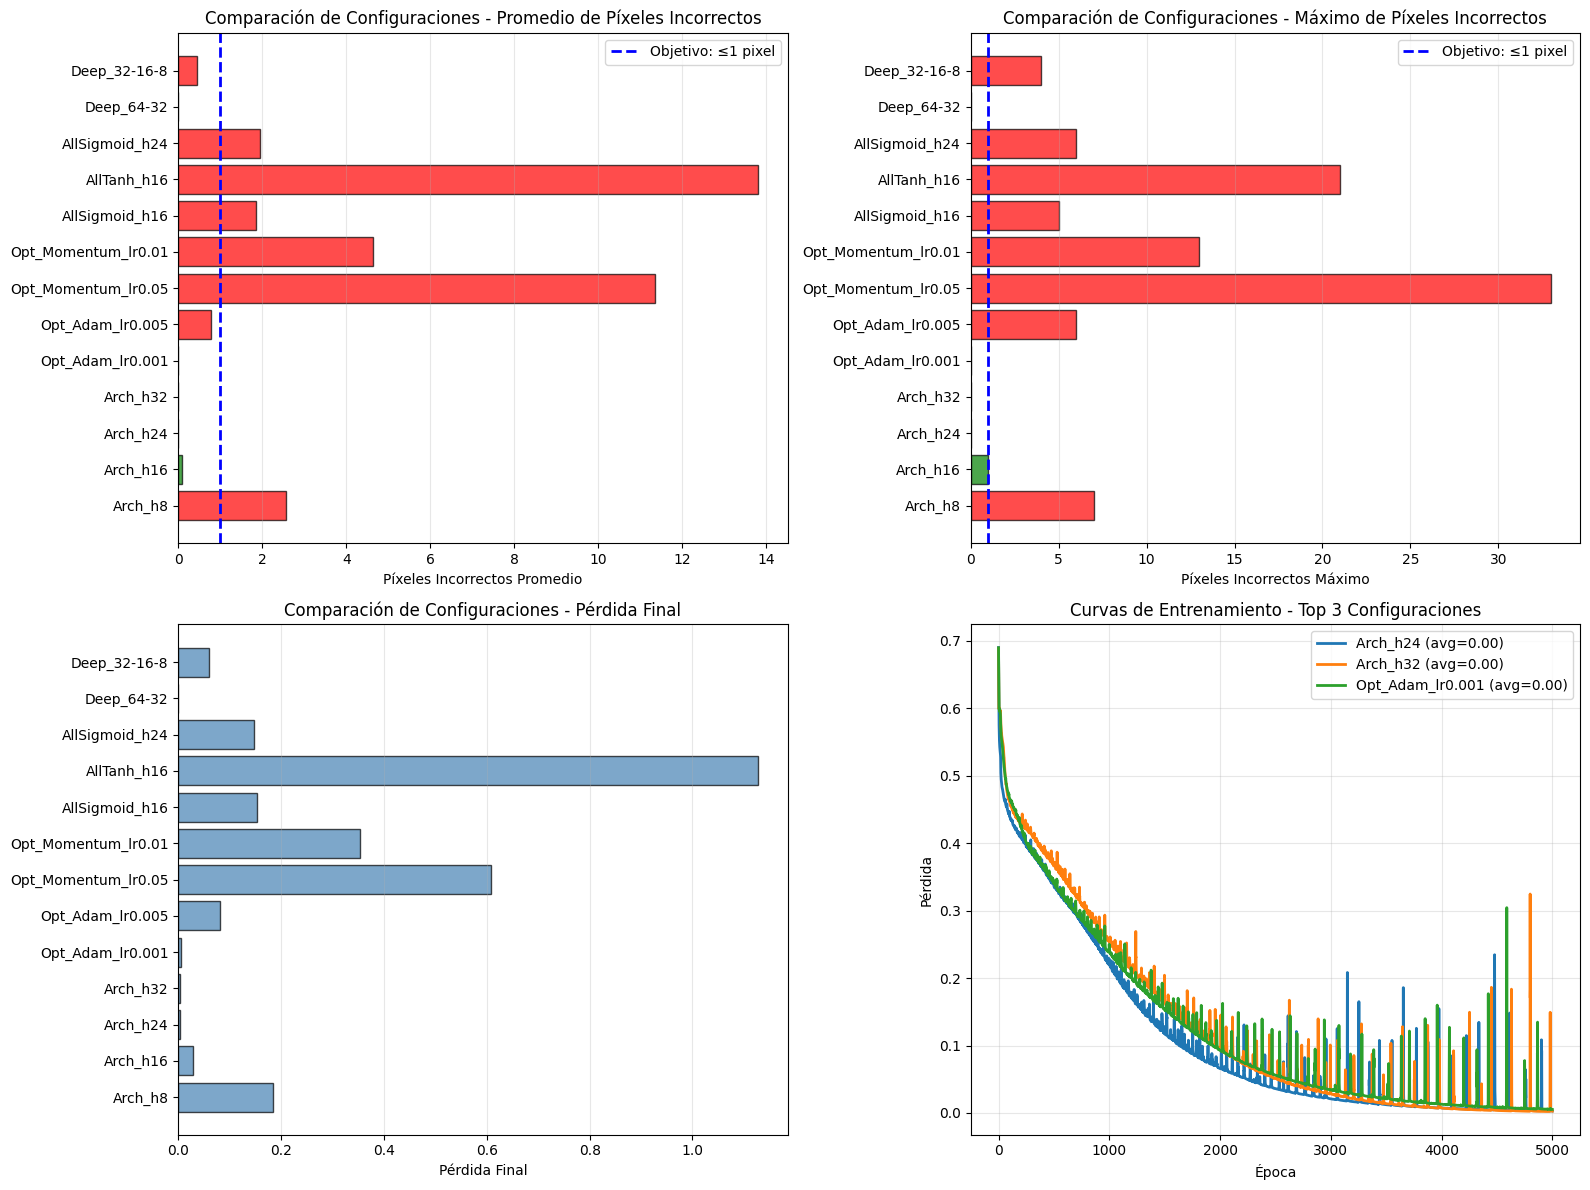

In [30]:
# Gráfico 1: Comparación de píxeles incorrectos promedio
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Píxeles incorrectos promedio por configuración
ax1 = axes[0, 0]
names = [r['name'] for r in results]
avg_incorrect = [r['avg_incorrect'] for r in results]
max_incorrect = [r['max_incorrect'] for r in results]

colors = ['green' if m <= 1 else 'orange' if m <= 2 else 'red' for m in max_incorrect]
bars = ax1.barh(names, avg_incorrect, color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(x=1, color='blue', linestyle='--', linewidth=2, label='Objetivo: ≤1 pixel')
ax1.set_xlabel('Píxeles Incorrectos Promedio')
ax1.set_title('Comparación de Configuraciones - Promedio de Píxeles Incorrectos')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Subplot 2: Píxeles incorrectos máximo por configuración
ax2 = axes[0, 1]
bars2 = ax2.barh(names, max_incorrect, color=colors, alpha=0.7, edgecolor='black')
ax2.axvline(x=1, color='blue', linestyle='--', linewidth=2, label='Objetivo: ≤1 pixel')
ax2.set_xlabel('Píxeles Incorrectos Máximo')
ax2.set_title('Comparación de Configuraciones - Máximo de Píxeles Incorrectos')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Subplot 3: Pérdida final
ax3 = axes[1, 0]
final_losses = [r['final_loss'] for r in results]
bars3 = ax3.barh(names, final_losses, color='steelblue', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Pérdida Final')
ax3.set_title('Comparación de Configuraciones - Pérdida Final')
ax3.grid(axis='x', alpha=0.3)

# Subplot 4: Curva de entrenamiento de las top 3
ax4 = axes[1, 1]
for i, result in enumerate(results_sorted[:3]):
    ax4.plot(result['history'], label=f"{result['name']} (avg={result['avg_incorrect']:.2f})", linewidth=2)
ax4.set_xlabel('Época')
ax4.set_ylabel('Pérdida')
ax4.set_title('Curvas de Entrenamiento - Top 3 Configuraciones')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()